In [ ]:
import yfinance as yf

sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = 'max')
sp500

In [ ]:
sp500.index

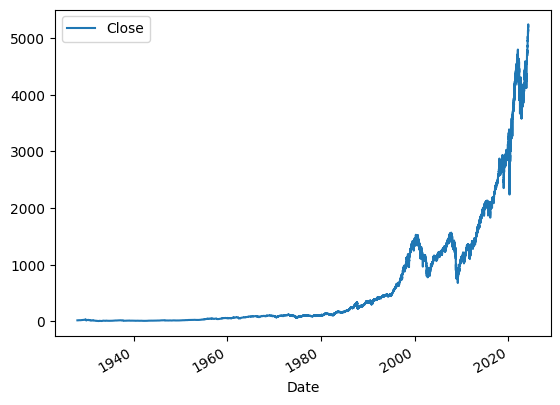

In [7]:
sp500.plot.line(y = 'Close', use_index = True)
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-03-20 00:00:00-04:00,5181.689941,5226.189941,5171.549805,5224.620117,4064850000,5241.529785,1
2024-03-21 00:00:00-04:00,5253.430176,5261.100098,5240.660156,5241.529785,4207730000,5234.180176,0
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000,5218.189941,0


In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score
import pandas as pd

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

precision_score(test["Target"], preds)

0.65

<Axes: xlabel='Date'>

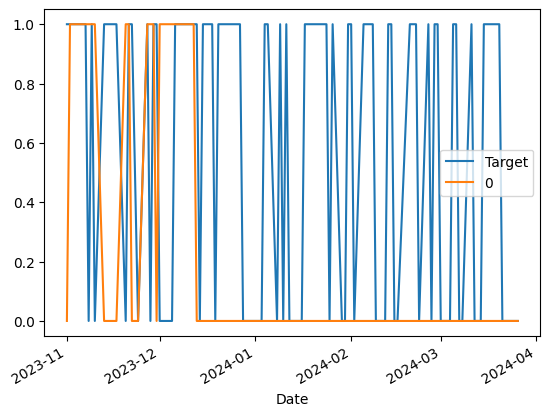

In [13]:
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined


def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

Predictions
0    3528
1    2596
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [16]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
1    0.534618
0    0.465382
Name: count, dtype: float64

In [17]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

trend_column = f"Trend_{horizon}"
sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

new_predictors += [ratio_column, trend_column]
sp500 = sp500.dropna().copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,0.996617,1.000283,1.028047,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.995899,0.997329,1.025151,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,0.999495,1.000311,1.028274,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,1.004991,1.006561,1.034781,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.003784,1.005120,1.033359,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19 00:00:00-04:00,5139.089844,5180.310059,5131.589844,5178.509766,4031760000,5224.620117,1,1.002817,1.005114,1.047818,1.152992,1.271007,533.0
2024-03-20 00:00:00-04:00,5181.689941,5226.189941,5171.549805,5224.620117,4064850000,5241.529785,1,1.004432,1.011734,1.055447,1.161926,1.281507,533.0
2024-03-21 00:00:00-04:00,5253.430176,5261.100098,5240.660156,5241.529785,4207730000,5234.180176,0,1.001616,1.011442,1.057130,1.164347,1.284817,534.0


In [18]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    3702
1.0    1421
Name: count, dtype: int64

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5116115411681914